In [244]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
import matplotlib.dates as mdates

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 3,    
    'lines.markersize': 6  
})

In [2]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

# Fetching data and preprocessing

In [3]:
import yfinance as yf
import pandas as pd

tickers = ["^DJI", "^GSPC", "^IXIC"]
start_date = "2024-01-01"
end_date = "2025-01-01"

# Download data with auto_adjust=True
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
    auto_adjust=True
)

# Create an empty DataFrame to hold all Close prices
close_df = pd.DataFrame()

for ticker in tickers:
    # Extract Close prices with ticker name as column name
    close_df[ticker.replace('^', '')] = data[ticker]['Close']

# The index is already the date, but just to be sure:
close_df.index = pd.to_datetime(close_df.index)

print(close_df.head())


[*********************100%***********************]  3 of 3 completed

                     DJI         GSPC          IXIC
Date                                               
2024-01-02  37715.039062  4742.830078  14765.940430
2024-01-03  37430.191406  4704.810059  14592.209961
2024-01-04  37440.339844  4688.680176  14510.299805
2024-01-05  37466.109375  4697.240234  14524.070312
2024-01-08  37683.011719  4763.540039  14843.769531


In [4]:
def add_focused_outliers(Y, begin_idx, num_outliers, y_value):
    """
    Replace `num_outliers` values in the first column of Y starting from `begin_idx` with `y_value`.

    Parameters:
    Y (np.ndarray): Original N x D array
    begin_idx (int): Starting index for the outliers
    num_outliers (int): Number of outliers to insert
    y_value (float): The value to use for the outliers

    Returns:
    np.ndarray: Modified array with outliers
    """
    Y_with_outliers = Y.copy()
    end_idx = min(begin_idx + num_outliers, Y.shape[0])  # prevent going out of bounds
    Y_with_outliers[begin_idx:end_idx, 0] = y_value
    return Y_with_outliers

def vshaped_outliers(Y, begin_idx, y_values):
    """
    Replace values in the first column of Y starting from `begin_idx` with 
    the original value multiplied by corresponding values in `y_values`.

    Parameters:
    Y (np.ndarray): Original N x D array
    begin_idx (int): Starting index for modifying values
    y_values (list of float): List of fractions to multiply with the original values

    Returns:
    np.ndarray: Modified array with V-shaped outliers
    """
    Y_modified = Y.copy()
    end_idx = min(begin_idx + len(y_values), Y.shape[0])  # avoid going out of bounds
    num_replace = end_idx - begin_idx  # actual number of values to replace

    # Convert y_values to a numpy array in case it's a list
    y_values_arr = np.array(y_values[:num_replace])

    # Apply the transformation
    Y_modified[begin_idx:end_idx, 0] *= y_values_arr

    return Y_modified

X shape: (252, 1)
Y shape: (252, 3)


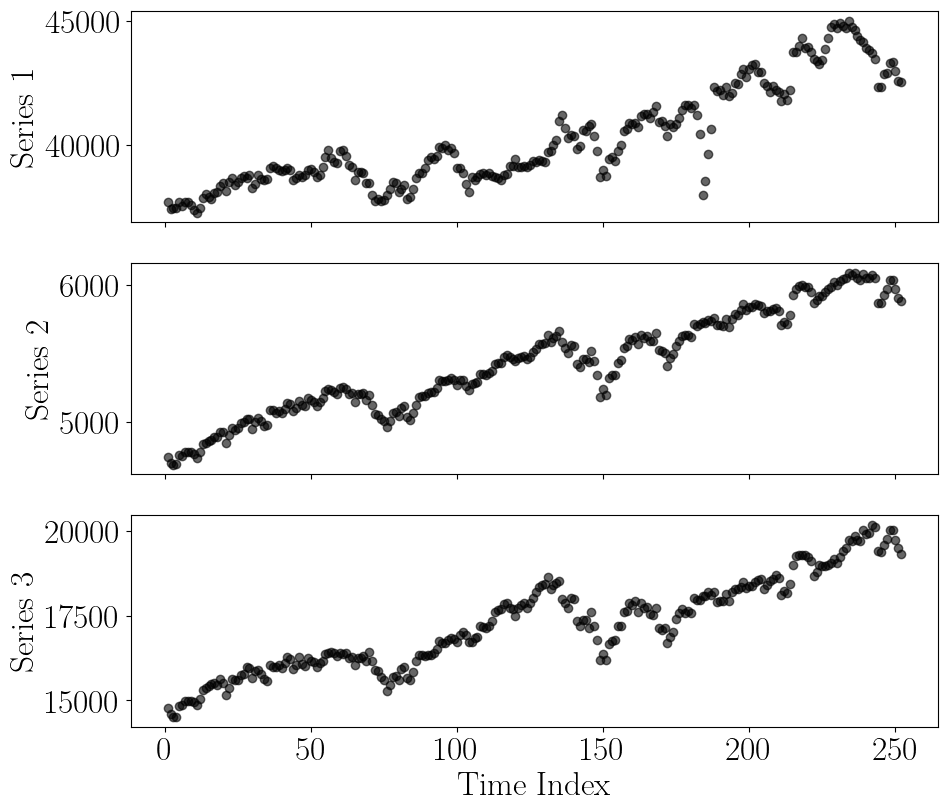

In [122]:
# Drop any rows with missing values to ensure clean arrays
clean_df = close_df.dropna()

# Number of data points (N)
N = clean_df.shape[0]

# Create X: array from 1 to N, shape (N, 1)
X = np.arange(1, N + 1).reshape(-1, 1)
X_test = np.linspace(1, N+1, 1000).reshape(-1, 1)

# Create Y: Close prices as (N, 4) array
Y = clean_df.to_numpy()

# Optional: check shapes
print("X shape:", X.shape)  # (N, 1)
print("Y shape:", Y.shape)  # (N, 4)

# Y_with_outliers = add_focused_outliers(Y, 120, 10, 35_000)
Y_with_outliers = vshaped_outliers(Y=Y, begin_idx=180, y_values=[0.99, 0.98, 0.96, 0.9, 0.92, 0.94, 0.96])


# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers[:, i], 'o', color='black', alpha=0.6)
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [123]:
scaler_Y_outliers = StandardScaler()
Y_with_outliers_standardized = scaler_Y_outliers.fit_transform(Y_with_outliers)

scaler_Y = StandardScaler()
Y_standardized = scaler_Y.fit_transform(Y)

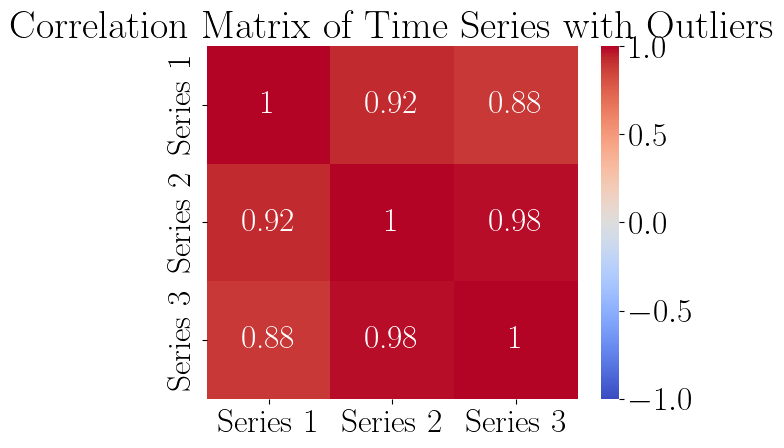

In [124]:
# Compute the correlation matrix
corr_matrix = np.corrcoef(Y_with_outliers.T)

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=[f'Series {i+1}' for i in range(3)],
            yticklabels=[f'Series {i+1}' for i in range(3)])
plt.title("Correlation Matrix of Time Series with Outliers")
plt.tight_layout()
plt.show()

## MOGP

fitted data
-371.19168409135284
-371.19168236212965
-371.1916814542599
-371.1916846347764
-371.1916814401958
-371.1917213798605
-371.1916466241569
-371.1916783402279
-371.1916915515458
-371.1916479583517
-371.19171929056597
156.85341143179357
156.85341346944608
156.85341102216887
156.853411136163
156.85341103100825
156.85341092014312
156.85341116686607
156.85341324153183
156.853410812574
156.8534097790773
156.85341206120472
170.23202138281908
170.2320232243968
170.23202097022727
170.23202103856124
170.2320209778136
170.23202123639305
170.23202123920123
170.23202222871396
170.2320204423711
170.23202032742506
170.23202224287468
205.48843933893545
205.4884400131674
205.48843899317694
205.4884389575849
205.4884390152523
205.48843972491068
205.4884390363569
205.4884382062329
205.4884391193092
205.48843986471468
205.48843970421615
214.164167122599
214.16416744679339
214.1641668695139
214.16416678256007
214.16416684183287
214.1641672913321
214.1641667189008
214.164166944954
214.1641676251936


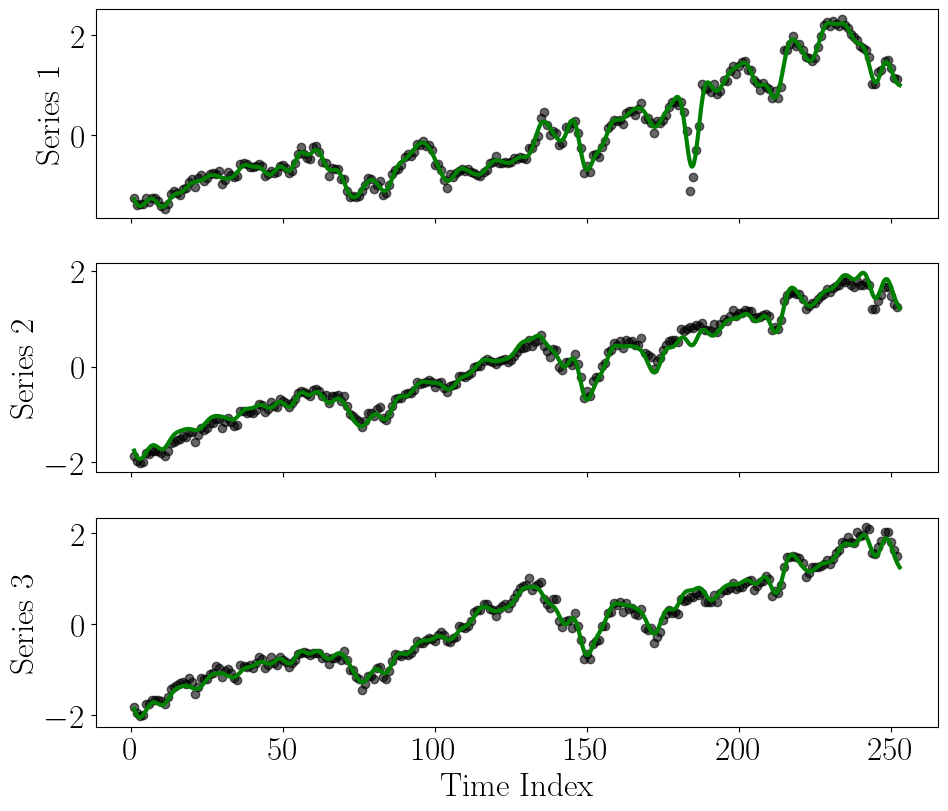

In [125]:
initial_A = generate_A(d = 3, r = 2)
mogp = MOGPRegressor(mean=0, length_scale=3.4, noise=np.array([0.02]*3), A=initial_A)
mogp.fit(X, Y_with_outliers_standardized)
print('fitted data')
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True, print_iter_param=True)
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

mu_mogp_standardized, var_mogp_standardized = mogp.predict(X_test)
# std_mogp = np.sqrt(var_mogp + mogp.noise)

# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers_standardized[:, i], 'o', color='black', alpha=0.6)
    axes[i].plot(X_test, mu_mogp_standardized[:, i], '-', color='green')
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [126]:
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X, Y_with_outliers_standardized, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, update_weights=True)

mu_morcgp_standardized, var_morcgp_standardized = morcgp.predict(X_test)
# std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

450.7250100251425
450.7250095262127
450.7250096767944
450.7250097598144
450.72500962910266
450.7250101699339
450.72500974342876
450.72500980377544
450.7250113057399
450.725010189681
450.7250090988305
-617.9798657180667
-617.9798643655821
-617.979855241342
-617.9798639370023
-617.979865415014
-617.9798397279143
-617.979852445127
-617.9798793251161
-617.9798729174152
-617.9798737385078
-617.979869516254
449.45280595199375
449.4528055058222
449.45280560545484
449.45280573407223
449.452805550234
449.4528062369057
449.4528067897476
449.45280535735606
449.4528032725629
449.4528063632244
449.45280798903394
451.82902781332257
451.8290273338537
451.82902746453374
451.8290275542844
451.8290274089738
451.82902800709644
451.82902791227133
451.8290274427828
451.82902749192976
451.8290280820266
451.8290281396387
Optimized length_scale: 3.3629
Optimized noise: [0.00999336 0.01331132 0.01103473]
Optimized A: [[0.41887314 0.67928019]
 [0.62413434 0.41467659]
 [0.67369    0.3078516 ]]
Optimized B: 
[[0.

In [127]:
morcgp_pm = MORCGPRegressor_PM(mean = 0, length_scale=3.5, noise = optim_noise, A=optim_A, epsilons=np.array([7/252, 0, 0]))
morcgp_pm.fit(X, Y_with_outliers_standardized)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )


mu_pm_standardized, _ = morcgp_pm.predict(X_test)

463.5265767372202
463.52657538018525
463.52657661900497
463.5265766909187
463.52657665493825
463.5265767179134
463.526576806392
463.5265769096645
463.5265776112025
463.526576700152
463.5265759485214
-1264.3696721370418
-1264.3696640003013
-1264.3696614059975
-1264.3696658401418
-1264.36967241785
-1264.369607763795
-1264.369653711389
-1264.3697225402582
-1264.3696876392316
-1264.3696574503088
-1264.3696668700763
464.6770508015964
464.6770496890267
464.6770506799909
464.67705077140283
464.67705070116176
464.6770511066471
464.6770516117996
464.6770498340087
464.67704866111035
464.67705160064776
464.67705236449274
Optimized length_scale: 3.4289
Optimized noise: [0.009999   0.01332585 0.01105051]
Optimized A: [[0.41760423 0.68222675]
 [0.62823449 0.41924382]
 [0.67201939 0.30218248]]
Optimized B: 
[[0.63982663 0.54837273 0.48679511]
 [0.54837273 0.57044396 0.5488739 ]
 [0.48679511 0.5488739  0.54292431]]


In [128]:
mu_mogp = scaler_Y_outliers.inverse_transform(mu_mogp_standardized)
mu_morcgp = scaler_Y_outliers.inverse_transform(mu_morcgp_standardized)
mu_pm = scaler_Y_outliers.inverse_transform(mu_pm_standardized)

morcgp_w01 = morcgp.w01.reshape(3,-1).T
pm_w01 = morcgp_pm.w01.reshape(3,-1).T

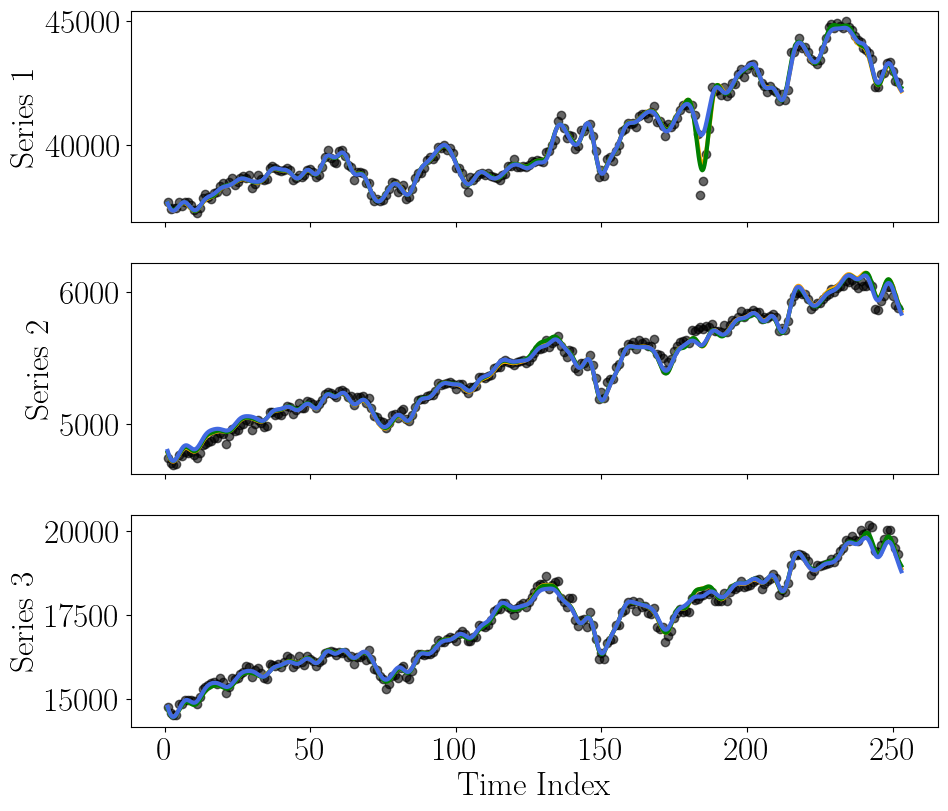

In [136]:
# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers[:, i], 'o', color='black', alpha=0.6)
    axes[i].plot(X_test, mu_pm[:, i], '-', color='Orange')
    axes[i].plot(X_test, mu_mogp[:, i], '-', color='Green')
    axes[i].plot(X_test, mu_morcgp[:, i], '-', color='RoyalBlue')
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

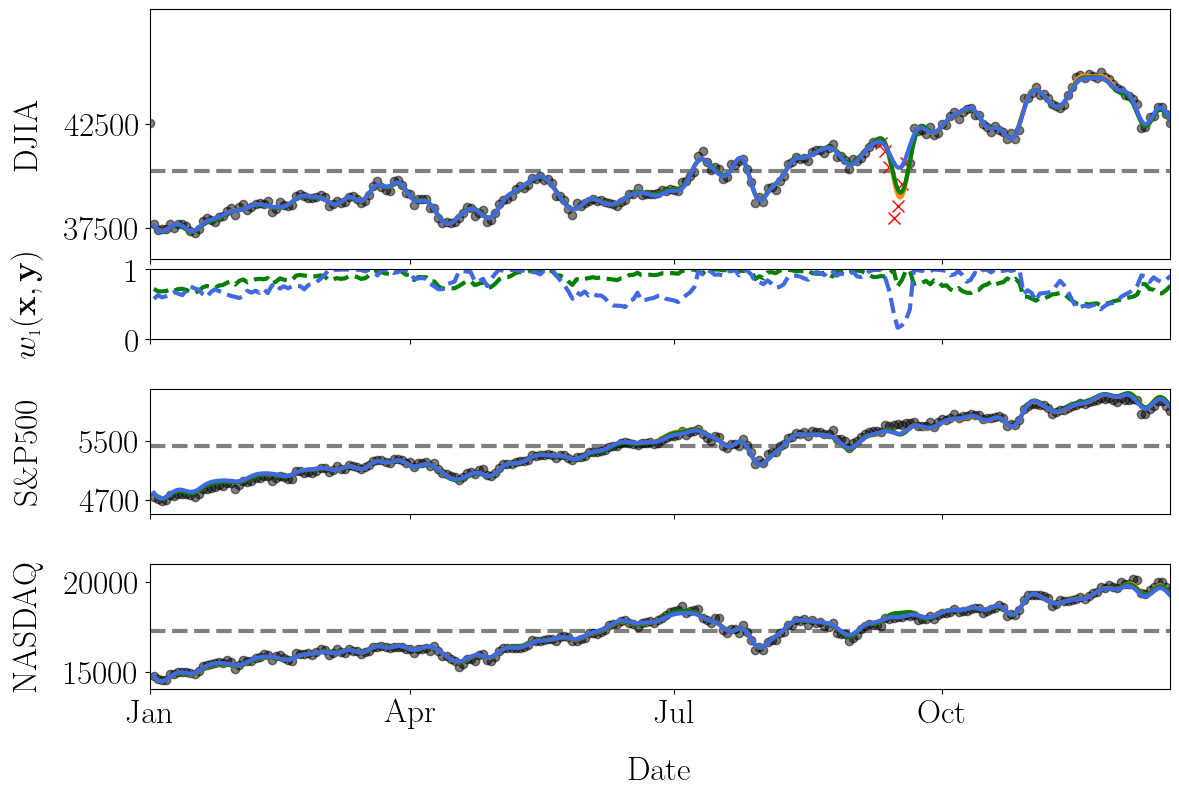

In [158]:
def plot_predictions(X, Y_with_outliers, mu_mogp, mu_morcgp, mu_pm, w_morcgp, w_pm, X_test):
    N = X.shape[0]
    N_test = X_test.shape[0]

    # Generate list of weekday dates starting from Jan 2, 2024
    start_date = datetime.date(2024, 1, 2)
    dates = []
    current_date = start_date
    while len(dates) < N:
        if current_date.weekday() < 5:
            dates.append(current_date)
        current_date += datetime.timedelta(days=1)

    quarters = [1, 4, 7, 10]
    seen = set()
    tick_dates = []
    tick_positions = []
    for i, date in enumerate(dates):
        key = (date.year, date.month)
        if date.month in quarters and key not in seen:
            tick_dates.append(date)
            tick_positions.append(i)  # numeric position for this tick
            seen.add(key)

    tick_labels = [d.strftime('%b') for d in tick_dates]
    exclude_slice = slice(180, 187)

    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True,
                            gridspec_kw={'height_ratios': [2, 0.4, 0.75, 0.75]})

    y_lims = [(36_000, 48_000), (0, 1), (4500, 6200), (14_000, 21_000)]
    y_ticks = [[37500, 42500], None, [4700, 5500], [15000, 20000]]
    labels = [r'DJIA', r'$w_{\scriptscriptstyle 1}(\mathbf{x}, \mathbf{y})$', r'S\&P500', r'NASDAQ']

    # Plot first subplot (index 0)
    i = 0
    mean_val = np.mean(Y_with_outliers[:, i])
    axs[i].axhline(mean_val, color='grey', linestyle='--', linewidth=3)

    # Observed data plot: numeric X positions for actual dates (exclude outliers)
    non_outlier_idx = [j for j in range(N) if j not in range(exclude_slice.start, exclude_slice.stop)]
    axs[i].plot(
        non_outlier_idx,
        Y_with_outliers[[j-1 for j in non_outlier_idx], i],
        'o', color='black', alpha=0.5
    )
    # Outliers
    outlier_idx = list(range(exclude_slice.start, exclude_slice.stop))
    axs[i].plot(
        outlier_idx,
        Y_with_outliers[outlier_idx, i],
        'x', color='red', markersize=8,
    )

    # Plot predictions using X_test numeric positions (assumed 0-based or aligned to trading days)
    axs[i].plot(X_test.flatten(), mu_mogp[:, i], '-', color='DarkOrange', label='MOGP')
    axs[i].plot(X_test.flatten(), mu_pm[:, i], '-', color='Green', label='PM')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label='MORCGP')

    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])

    # Plot weights subplot (index 1) - same numeric X as original data
    i = 1
    axs[i].plot(X.flatten(), w_pm[:, 0], '--', color='Green', linewidth=3, label='PM')
    axs[i].plot(X.flatten(), w_morcgp[:, 0], '--', color='RoyalBlue', linewidth=3, label='MORCGP')
    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    if y_ticks[i]:
        axs[i].set_yticks(y_ticks[i])

    # Plot second original subplot now index 2, with X_test for predictions
    i = 2
    mean_val = np.mean(Y_with_outliers[:, i - 1])
    axs[i].axhline(mean_val, color='grey', linestyle='--')
    axs[i].plot(X.flatten(), Y_with_outliers[:, 1], 'o', color='black', alpha=0.5)
    axs[i].plot(X_test.flatten(), mu_mogp[:, 1], '-', color='DarkOrange')
    axs[i].plot(X_test.flatten(), mu_pm[:, 1], '-', color='Green')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, 1], '-', color='RoyalBlue')
    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])

    # Plot third original subplot now index 3, with X_test for predictions
    i = 3
    mean_val = np.mean(Y_with_outliers[:, i - 1])
    axs[i].axhline(mean_val, color='grey', linestyle='--')
    axs[i].plot(X.flatten(), Y_with_outliers[:, 2], 'o', color='black', alpha=0.5)
    axs[i].plot(X_test.flatten(), mu_mogp[:, 2], '-', color='DarkOrange')
    axs[i].plot(X_test.flatten(), mu_pm[:, 2], '-', color='Green')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, 2], '-', color='RoyalBlue')
    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])

    axs[-1].set_xlabel("Date", labelpad=20)
    fig.align_ylabels(axs)

    # Set manual positions for subplots as you had them
    fig_height = 0.95  # total height available
    top = 0.95
    bottom = 0.05
    gap_large = 0.05
    gap_small = 0.01

    h1 = 0.25
    h2 = 0.07
    h3 = 0.125
    h4 = 0.125

    b1 = top - h1
    b2 = b1 - gap_small - h2
    b3 = b2 - gap_large - h3
    b4 = b3 - gap_large - h4

    axs[0].set_position([0.1, b1, 0.85, h1])
    axs[1].set_position([0.1, b2, 0.85, h2])
    axs[2].set_position([0.1, b3, 0.85, h3])
    axs[3].set_position([0.1, b4, 0.85, h4])

    plt.show()
    # fig.savefig("./financial_MOGP_weights.pdf", format='pdf', bbox_inches='tight')

plot_predictions(X=X, Y_with_outliers=Y_with_outliers, mu_mogp=mu_mogp, mu_morcgp=mu_morcgp, mu_pm=mu_pm, w_morcgp=morcgp_w01, w_pm=pm_w01, X_test=X_test)

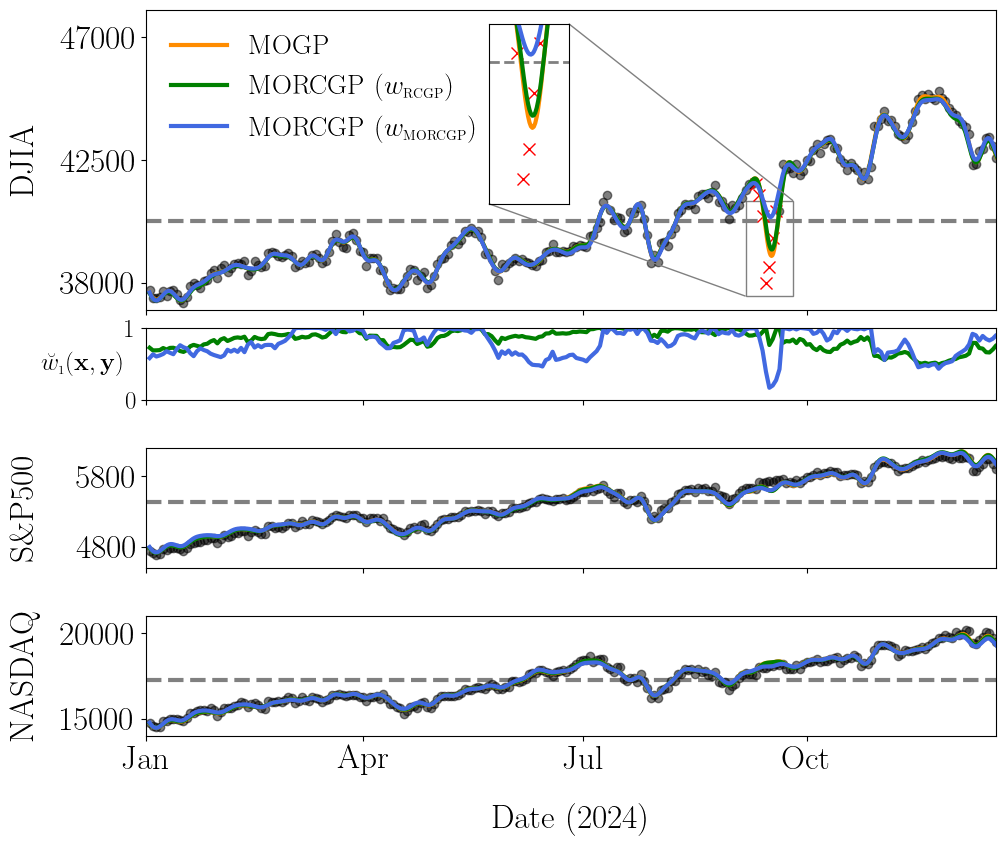

In [ ]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_predictions(X, Y_with_outliers, mu_mogp, mu_morcgp, mu_pm, w_morcgp, w_pm, X_test):
    N = X.shape[0]
    N_test = X_test.shape[0]

    # Generate list of weekday dates starting from Jan 2, 2024
    start_date = datetime.date(2024, 1, 2)
    dates = []
    current_date = start_date
    while len(dates) < N:
        if current_date.weekday() < 5:
            dates.append(current_date)
        current_date += datetime.timedelta(days=1)

    quarters = [1, 4, 7, 10]
    seen = set()
    tick_dates = []
    tick_positions = []
    for i, date in enumerate(dates):
        key = (date.year, date.month)
        if date.month in quarters and key not in seen:
            tick_dates.append(date)
            tick_positions.append(i)
            seen.add(key)

    tick_labels = [d.strftime('%b') for d in tick_dates]
    exclude_slice = slice(180, 187)

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True,
                            gridspec_kw={'height_ratios': [2.5, 0.4, 0.3, 0.3]})

    y_lims = [(37_000, 48_000), (0, 1), (4500, 6200), (14_000, 21_000)]
    y_ticks = [[38000, 42500, 47000], [0, 1], [4800, 5800], [15000, 20000]]
    labels = [r'DJIA', r'$\breve{w}_{\scriptscriptstyle 1}(\mathbf{x}, \mathbf{y})$', r'S\&P500', r'NASDAQ']

    # Plot first subplot (index 0)
    i = 0
    mean_val = np.mean(Y_with_outliers[:, i])
    axs[i].axhline(mean_val, color='grey', linestyle='--', linewidth=3)

    non_outlier_idx = [j for j in range(N) if j not in range(exclude_slice.start, exclude_slice.stop)]
    axs[i].plot(
        non_outlier_idx[1:],
        Y_with_outliers[[j-1 for j in non_outlier_idx[1:]], i],
        'o', color='black', alpha=0.5
    )
    outlier_idx = list(range(exclude_slice.start, exclude_slice.stop))
    axs[i].plot(
        outlier_idx,
        Y_with_outliers[outlier_idx, i],
        'x', color='red', markersize=8,
    )
    axs[i].plot(X_test.flatten(), mu_mogp[:, i], '-', color='DarkOrange', label='MOGP')
    axs[i].plot(X_test.flatten(), mu_pm[:, i], '-', color='Green', label=r'MORCGP ($w_{\scriptscriptstyle \textup{RCGP}}$)')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=r'MORCGP ($w_{\scriptscriptstyle \textup{MORCGP}}$)')

    # Add zoomed inset for subplot 0
    axins = inset_axes(
        axs[0],
        width=0.8,
        height=1.8,
        loc='upper center',
        bbox_to_anchor=(0.45, 1),
        bbox_transform=axs[0].transAxes
    )
    axins.axhline(mean_val, color='grey', linestyle='--', linewidth=2)
    axins.plot(
        non_outlier_idx,
        Y_with_outliers[[j for j in non_outlier_idx], 0],
        'o', color='black', alpha=0.5
    )
    axins.plot(
        outlier_idx,
        Y_with_outliers[outlier_idx, 0],
        'x', color='red', markersize=8,
    )
    axins.plot(X_test.flatten(), mu_mogp[:, 0], '-', color='DarkOrange')
    axins.plot(X_test.flatten(), mu_pm[:, 0], '-', color='Green')
    axins.plot(X_test.flatten(), mu_morcgp[:, 0], '-', color='RoyalBlue')
    axins.set_xlim(177, 191)
    axins.set_ylim(37500, 41000)
    axins.set_xticks([])
    axins.set_yticks([])
    mark_inset(axs[0], axins, loc1=3, loc2=1, fc="none", ec="0.5")

    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])
    axs[i].legend(loc='upper left', frameon=False)

    # Plot weights subplot (index 1)
    i = 1
    axs[i].plot(X.flatten(), w_pm[:, 0], '-', color='Green', linewidth=3, label='PM')
    axs[i].plot(X.flatten(), w_morcgp[:, 0], '-', color='RoyalBlue', linewidth=3, label='MORCGP')

    # Horizontal y-axis label, with smaller labelpad
    axs[i].set_ylabel(labels[i], labelpad=1, rotation=0, ha='right', va='center', fontsize=18)

    # Smaller font size for y-ticks
    axs[i].tick_params(axis='y', labelsize=18)

    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    if y_ticks[i]:
        axs[i].set_yticks(y_ticks[i])


    # Subplot 2
    i = 2
    mean_val = np.mean(Y_with_outliers[:, i - 1])
    axs[i].axhline(mean_val, color='grey', linestyle='--')
    axs[i].plot(X.flatten(), Y_with_outliers[:, 1], 'o', color='black', alpha=0.5)
    axs[i].plot(X_test.flatten(), mu_mogp[:, 1], '-', color='DarkOrange')
    axs[i].plot(X_test.flatten(), mu_pm[:, 1], '-', color='Green')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, 1], '-', color='RoyalBlue')
    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])

    # Subplot 3
    i = 3
    mean_val = np.mean(Y_with_outliers[:, i - 1])
    axs[i].axhline(mean_val, color='grey', linestyle='--')
    axs[i].plot(X.flatten(), Y_with_outliers[:, 2], 'o', color='black', alpha=0.5)
    axs[i].plot(X_test.flatten(), mu_mogp[:, 2], '-', color='DarkOrange')
    axs[i].plot(X_test.flatten(), mu_pm[:, 2], '-', color='Green')
    axs[i].plot(X_test.flatten(), mu_morcgp[:, 2], '-', color='RoyalBlue')
    axs[i].set_ylabel(labels[i], labelpad=15)
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_xlim(0, N - 1)
    axs[i].set_ylim(y_lims[i])
    axs[i].set_yticks(y_ticks[i])

    axs[-1].set_xlabel("Date (2024)", labelpad=20)
    labels_to_align = [0,2,3]
    fig.align_ylabels(axs[labels_to_align])

    # Manual subplot layout
    fig_height = 0.95
    top = 0.95
    bottom = 0.05
    gap_large = 0.04
    gap_small = 0.015

    h1 = 0.25
    h2 = 0.06
    h3 = 0.1
    h4 = 0.1

    b1 = top - h1
    b2 = b1 - gap_small - h2
    b3 = b2 - gap_large - h3
    b4 = b3 - gap_large - h4

    axs[0].set_position([0.1, b1, 0.85, h1])
    axs[1].set_position([0.1, b2, 0.85, h2])
    axs[2].set_position([0.1, b3, 0.85, h3])
    axs[3].set_position([0.1, b4, 0.85, h4])

    plt.show()
    # fig.savefig("./financial_MOGP_weights.pdf", format='pdf', bbox_inches='tight')


plot_predictions(X=X, Y_with_outliers=Y_with_outliers, mu_mogp=mu_mogp, mu_morcgp=mu_morcgp, mu_pm=mu_pm, w_morcgp=morcgp_w01, w_pm=pm_w01, X_test=X_test)